In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [2]:
def adjoint(M):
  return np.transpose(np.conj(M))

def binary_entropy(x):
  return -x*np.log2(x)-(1-x)*np.log2(1-x) if x > 0 and x <1 else 0

In [3]:
nomralization = 1/np.sqrt(2)

I2 = np.identity(2)
I4 = np.identity(4)
I8 = np.identity(8)
I16 = np.identity(16)
I64 = np.identity(64)
proj0 = [[1,0],[0,0]]
proj1 = [[0,0],[0,1]]
X = [[0,1],[1,0]]
Y = [[0,complex(0,-1)],[complex(0,1),0]]

def rx(theta):
  a = complex(np.cos(theta),0)
  b = complex(0,np.sin(theta))
  M = np.array([[a,-b],[b,a]]) 
  return M

def ry(theta):
  a = complex(np.cos(theta),0)
  b = complex(np.sin(theta),0)
  M = np.array([[a,b],[-b,a]])
  return M



cx_next = np.array([[1,0,0,0],
              [0,1,0,0],
              [0,0,0,1],
              [0,0,1,0]])

cx_15 = np.kron(I2,np.kron(proj0,I64)) + np.kron(I2,np.kron(proj1,np.kron(I8,np.kron(X,I4))))

R = np.array([[nomralization,nomralization],
              [-nomralization,nomralization]])

  
initial = [.5,0,0,0,
           0,.5,0,0,
           0,0,.5,0,
           0,0,0,.5]

def pqc(theta,phi):
  #U = np.kron(rx(theta),ry(phi)) # first training landscape
  U = np.kron(ry(theta),ry(phi))
  U = np.matmul(U,cx_next)
  #return U
  #return np.matmul(U,U)
  U = np.matmul(U,U)
  U = np.matmul(U,U)
  return U

def measure(i,j):
  bit0 = proj0 if i == 0 else proj1
  bit1 = proj0 if j == 0 else proj1
  M = np.kron(bit0,bit1)
  partial_measurement = np.kron(I4,M)
  return partial_measurement

In [4]:
def concurrence(theta,phi,i,j):
  U = pqc(theta,phi)
  one_side = np.kron(I4,U)
  first_operation = np.kron(one_side,one_side)
  state = np.kron(initial,initial)
  state = np.matmul(first_operation,state)
  M = measure(i,j)
  M2 = np.kron(M,M)
  state = np.matmul(M2,state)
  ygates = np.kron(I16,np.kron(Y,np.kron(Y,I4)))
  state = np.matmul(ygates,state)
  state = np.matmul(cx_15,state)
  r_gate = np.kron(I2,np.kron(R,I64))
  state = np.matmul(r_gate,state)
  #conc = np.abs(state[0])**2
  index = i*(2**5+2) + j*(2**4+1)
  conc = np.abs(state[index]) #concurrence squared divided by 2
  return conc

In [5]:
def probability(theta,phi,i,j):
  state = initial
  state = np.matmul(np.kron(I4,pqc(theta,phi)),state)
  M = measure(i,j)
  state = np.matmul(M,state)
  probability = np.dot(np.conj(state),state)
  return probability

In [6]:
def entanglement(theta,phi):
  entropy = 0
  for i in range(2):
    for j in range(2):
      prob = probability(theta,phi,i,j)
      conc = concurrence(theta,phi,i,j)*8
      val = (1+np.sqrt(1-conc))/2
      entropy += prob*binary_entropy(val)

  return np.abs(entropy)

In [7]:
def grad_entanglement(theta,phi):
  delta = .0001
  first = entanglement(theta+delta,phi)-entanglement(theta-delta,phi)
  first /= 2*delta
  second = entanglement(theta,phi+delta)-entanglement(theta,phi-delta)
  second /= 2*delta
  return np.array([first,second])

In [8]:
entanglement(0,0)

0.0

In [9]:
probability(.1,np.pi,1,1)

(0.2500000000000001+0j)

In [10]:
a = np.arange(0,2*np.pi,.5)
b = np.arange(0,2*np.pi,.5)
thetas,phis = np.meshgrid(a,b)
L = len(a)
Z = np.zeros((L,L))
for i in range(L):
  for j in range(L):
    x = a[i]
    y = b[j]
    Z[i,j]=entanglement(x,y)

Text(0.5, 0, 'z')

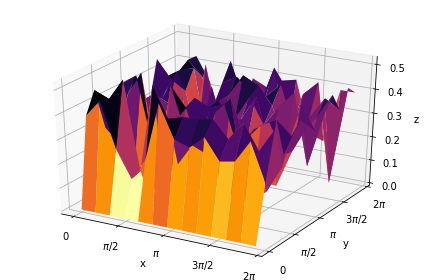

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(thetas, phis, Z,cmap='inferno_r')
ax.set_xticks(np.arange(0,2*np.pi+.001,np.pi/2))
ax.set_yticks(np.arange(0,2*np.pi+.001,np.pi/2))
labels = ['$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

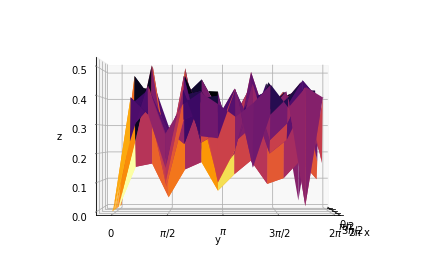

In [12]:
ax.view_init(0,0)
fig

In [13]:
epochs = 100
eta = .01
theta = 2*np.random.rand()
phi = 2*np.random.rand()
thetas = [theta]
phis = [phi]

In [14]:
for epoch in range(epochs):
  if epoch in range(15):
    eta = .1
  elif epoch in range(15,30):
    eta = .01
  elif epoch in range(30,75):
    eta = .0001
  else:
    eta = .000001
  grad = grad_entanglement(theta,phi)
  theta -= eta*grad[0]
  phi -= eta*grad[1]
  thetas.append(theta)
  phis.append(phi)

In [15]:
entanglements = [entanglement(thetas[i],phis[i]) for i in range(epochs+1)]

Text(0, 0.5, 'Error')

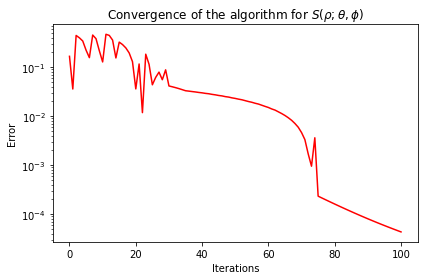

In [16]:
plt.plot(range(epochs+1),entanglements,color='red')
plt.yscale('log')
plt.title(r'Convergence of the algorithm for $S(\rho;\theta,\phi)$')
plt.xlabel('Iterations')
plt.ylabel('Error')

In [17]:
#two ry
a = np.arange(0,2*np.pi,.01)
b = np.arange(0,2*np.pi,.01)
thetas,phis = np.meshgrid(a,b)
L = len(a)
Z = np.zeros((L,L))
for i in range(L):
  for j in range(L):
    x = a[i]
    y = b[j]
    Z[i,j]=entanglement(x,y)

Text(0.5, 0.92, 'Training Landscape of $S(\\rho;\\theta,\\phi)$')

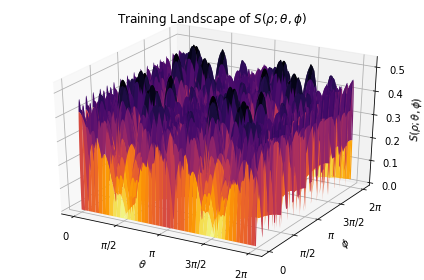

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(thetas, phis, Z,cmap='inferno_r')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\phi$')
ax.set_xticks(np.arange(0,2*np.pi+.001,np.pi/2))
ax.set_yticks(np.arange(0,2*np.pi+.001,np.pi/2))
labels = ['$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_zlabel(r'$S(\rho;\theta,\phi)$')
ax.set_title(r'Training Landscape of $S(\rho;\theta,\phi)$')

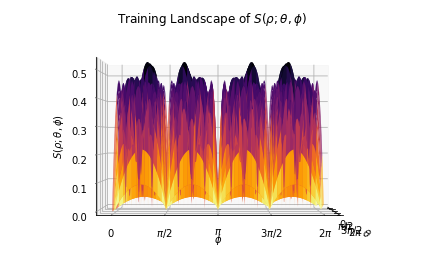

In [19]:
ax.view_init(0,0)
fig

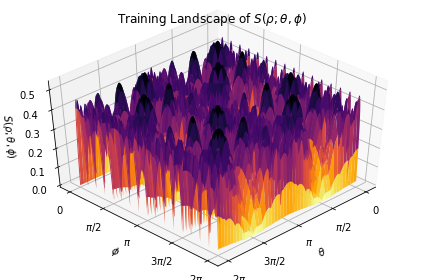

In [20]:
ax.view_init(45,45)
fig

In [21]:
#t_f training landscape and convergence 
def probs_and_phis(theta,phi):
  probabilities = []
  big_phis = []

  state = initial
  state = np.matmul(np.kron(I4,pqc(theta,phi)),state)
  for i in range(2):
    for j in range(2):
      M = measure(i,j)
      measurement = np.matmul(M,state)
      probability = np.dot(np.conj(measurement),measurement)
      probabilities.append(probability)

      outer_product = np.outer(measurement,measurement)
      partial_trace = np.array([[np.trace(outer_product[0:8,0:8]),np.trace(outer_product[0:8,8:16])],
                               [np.trace(outer_product[8:16,0:8]),np.trace(outer_product[8:16,8:16])]])
      
      big_phis.append(partial_trace)
  return probabilities,big_phis

In [22]:
def t_f(theta,phi):
  probabilities_and_big_phis = probs_and_phis(theta,phi)
  t = 0
  for i in range(4):
    p = probabilities_and_big_phis[0][i]
    state = probabilities_and_big_phis[1][i]
    t += p**2 - np.trace(np.matmul(state,state))
  
  return np.abs(t)

In [23]:
stuff = probs_and_phis(np.pi,np.pi)

In [24]:
stuff[0]

[(0.25+0j), (0.25+0j), (0.25+0j), (0.25+0j)]

In [25]:
x,y= np.random.rand(2,1)

In [26]:
t_f(x,y)

0.034797901822701434

In [27]:
a = np.arange(0,2*np.pi,.01)
b = np.arange(0,2*np.pi,.01)
thetas,phis = np.meshgrid(a,b)
L = len(a)
Z = np.zeros((L,L))
for i in range(L):
  for j in range(L):
    x = a[i]
    y = b[j]
    Z[i,j]=t_f(x,y)

Text(0.5, 0.92, 'Training Landscape of $T_f(\\rho;\\theta,\\phi)$')

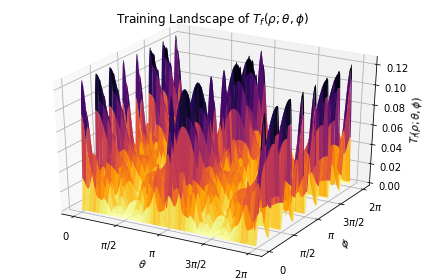

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(thetas, phis, Z,cmap='inferno_r')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\phi$')
ax.set_xticks(np.arange(0,2*np.pi+.001,np.pi/2))
ax.set_yticks(np.arange(0,2*np.pi+.001,np.pi/2))
labels = ['$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_zlabel(r'$T_f(\rho;\theta,\phi)$')
ax.set_title(r'Training Landscape of $T_f(\rho;\theta,\phi)$')

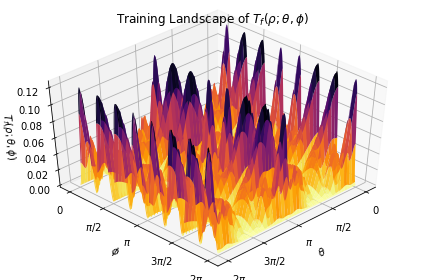

In [29]:
ax.view_init(45,45)
fig

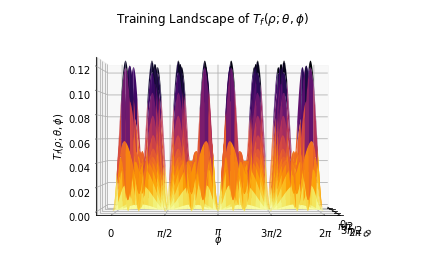

In [30]:
ax.view_init(0,0)
fig